## Unsupervised Clustering on UK Postcodes

In [ ]:
# The following code compares a number of unsupervised clustering algorithms applied to postcodes in the UK.

In [35]:
# Load libraries
%matplotlib inline 

import pandas as pd
import numpy as np
from sklearn import cluster, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.style.use('ggplot') 
from sklearn import datasets

from math import radians, cos, sin, asin, sqrt

from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN, KMeans

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Load data, removing anomoaly from data

X = pd.read_csv('https://www.freemaptools.com/download/outcode-postcodes/postcode-outcodes.csv')
X = X[X.latitude != 0]
X.head()

,id,postcode,latitude,longitude
0,2,AB10,57.13514,-2.11731
1,3,AB11,57.13875,-2.09089
2,4,AB12,57.10100,-2.11060
3,5,AB13,57.10801,-2.23776
4,6,AB14,57.10076,-2.27073


In [3]:
# Define function that calculates the distance between any two point on the earths surface using it longitude
# and latitude

def haversine(lonlat1, lonlat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lat1, lon1 = lonlat1
    lat2, lon2 = lonlat2
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2.)**2 + cos(lat1) * cos(lat2) * sin(dlon/2.)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of the Earth in kilometres.
    return c * r

In [4]:
# Calculate the distance matrix between any two points

my_metric = pdist(X.ix[:,['latitude','longitude']], (lambda u,v: haversine(u,v)))
distance_matrix = squareform(my_metric)

[-1  0  1  2  3  4  5  6  7  8  9 10 11]


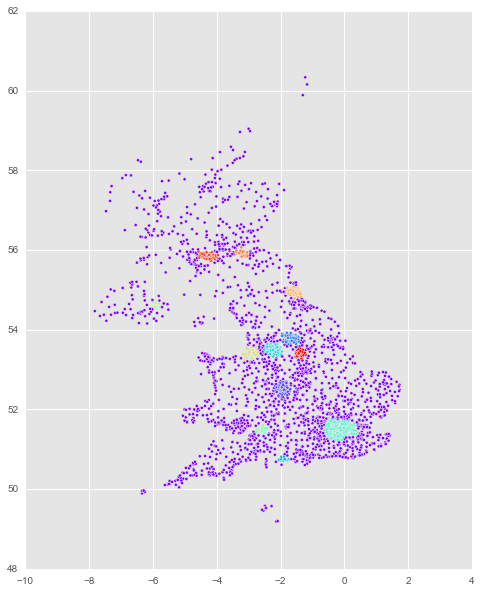

In [9]:
# Clustering using DBSCAN

# Density-based spatial clustering (DBSCAN) is a density-based, unsupervised clustering algorithm: given a set of 
# points in some space, it groups together points that are closely packed together (points with many nearby neighbors),
# marking as outliers points that lie alone in low-density regions. Points which are outliers, belong to no cluster, 
# are labeled by -1. 

# The algorithm works by first choosing an arbitrary point in the dataset. If there are more than a specified number 
# of points within a chosen distance of epsilon from that point, then those points are considered part of a cluster. 
# The cluster is then expanded by checking all of the new points and seeing if they too have more than a certain 
# number of points within a distance of epsilon. This process is continued until no new points are assigned to the 
# cluster. A new point at random is then chosen and the entire process is repeated. Points which are not assingned
# to any cluster are considered outliers or 'noise points'.

db = DBSCAN(eps= 10, min_samples= 20, metric='precomputed')  
# Fit on distance matrix
y_db = db.fit_predict(distance_matrix) 
labels = db.labels_

print np.unique(db.labels_)

plt.figure(figsize = (8, 10))
plt.scatter(X['longitude'], X['latitude'], c = labels, cmap = 'rainbow', s = 10 )
plt.show()

In [10]:
# With a minimum number of 20 points at specified distance 10, DBSCAN has identified a total of 10 unique clusters
# with the remainder of the points considered 'noise'. With the given parameters, DBSCAN has identified major
# cities across the UK where there is a high density of points.

In [12]:
# Clustering using Hierarchical Clustering

# The 'bottom up' approach to Hierarchical clustering work as follows: Each observation intially starts as its
# own cluster. The distance between each pair of clusters is then computed, and the closest pair is merged into
# its own cluster. This process is then repeated until we are left with one big cluster. An important consideration
# for the algorithm is the Cophenetic coefficient, which is a measure of how well the Dendogram preserves the pairwise
# distances of the original observations. A coefficient of 1 infers that the distances are perfectly preserved.

Z = linkage(distance_matrix, 'average') # Distance measure used between clusters is the average of cluster points
cophenet(Z, my_metric)
c, coph_dists = cophenet(Z, my_metric)
print 'Cophentic Coefficient: ', c
print 'Cophentic Distance: ', coph_dists.mean()

Cophentic Coefficient:  0.80408996952
Cophentic Distance:  10567.7638873


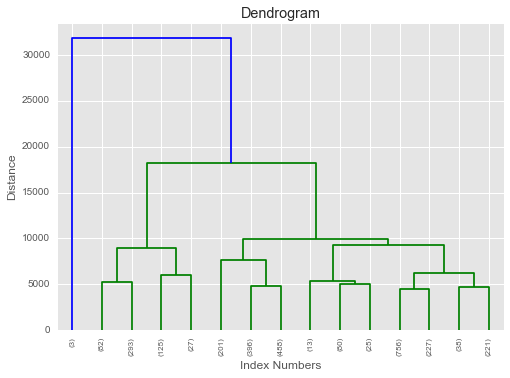

In [13]:
# Plot truncated Dendogram

plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode = 'lastp',
    p = 15,
    leaf_rotation=90.,  
    leaf_font_size=8.,
)
plt.show()

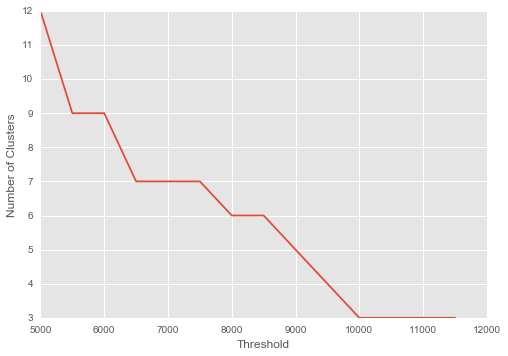

In [21]:
# Number of clusters varying the threshold

threshold = np.arange(5000, 12000, 500)
number_clusters = []

for i in threshold:
    clusters = fcluster(Z, i, criterion ='distance')
    number_clusters.append(clusters.max())
    
plt.plot(threshold, number_clusters)
plt.xlabel('Threshold')
plt.ylabel('Number of Clusters')
plt.show()

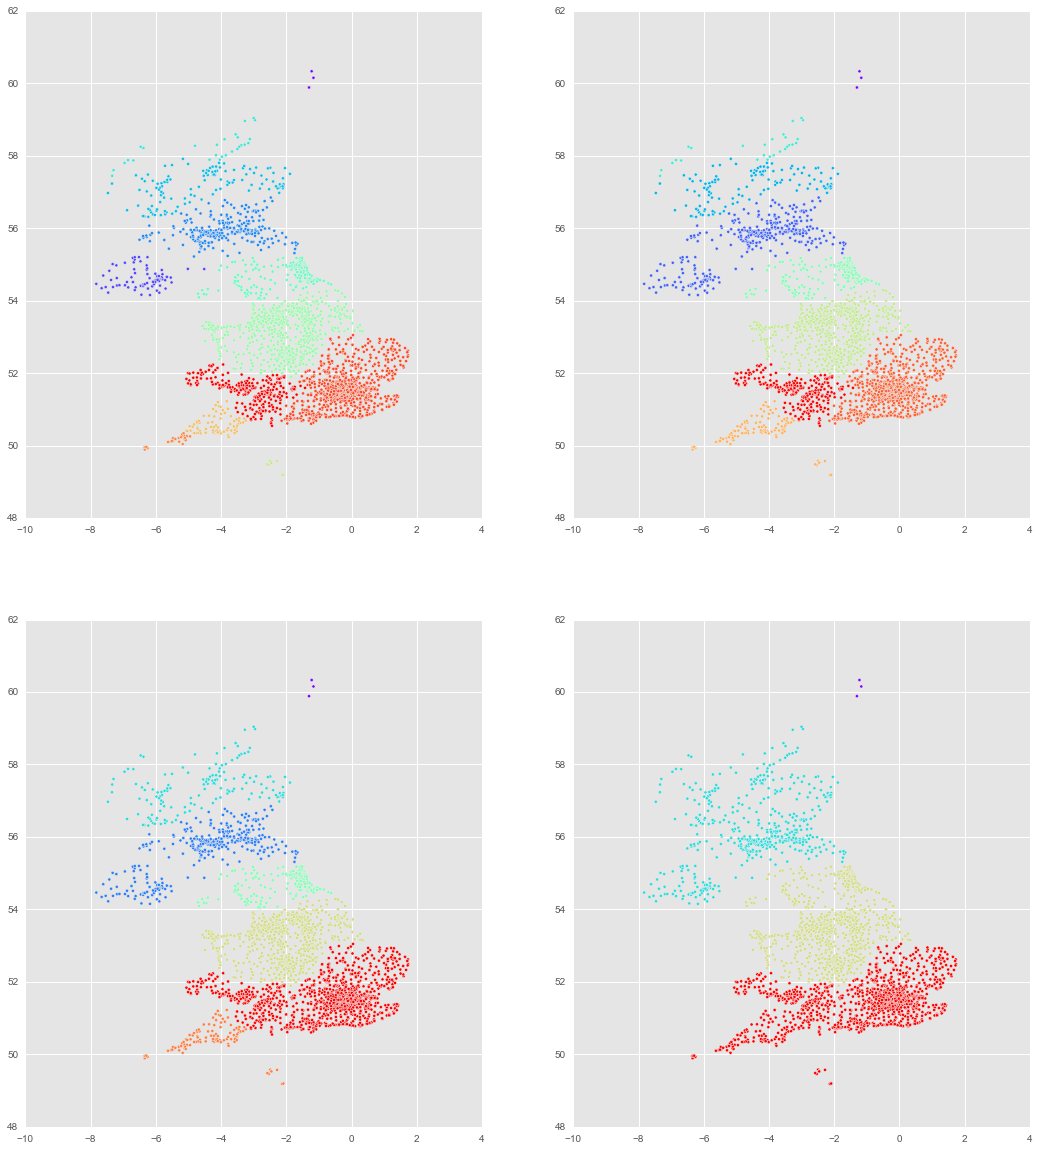

In [45]:
# Scatter plots for varying thresholds

fig = plt.figure(figsize=(18, 20))

fig.add_subplot(2, 2, 1)
plt.scatter(X['longitude'], X['latitude'], c = fcluster(Z, 5000, criterion ='distance'), cmap = 'rainbow', s = 10 )

fig.add_subplot(2, 2, 2)
plt.scatter(X['longitude'], X['latitude'], c = fcluster(Z, 6000, criterion ='distance'), cmap = 'rainbow', s = 10 )

fig.add_subplot(2, 2, 3)
plt.scatter(X['longitude'], X['latitude'], c = fcluster(Z, 7000, criterion ='distance'), cmap = 'rainbow', s = 10 )

fig.add_subplot(2, 2, 4)
plt.scatter(X['longitude'], X['latitude'], c = fcluster(Z, 9500, criterion ='distance'), cmap = 'rainbow', s = 10 )

plt.show()      

In [32]:
# Using Hierarchical Clustering, the algorithms has indentified major areas such as countries and counties.

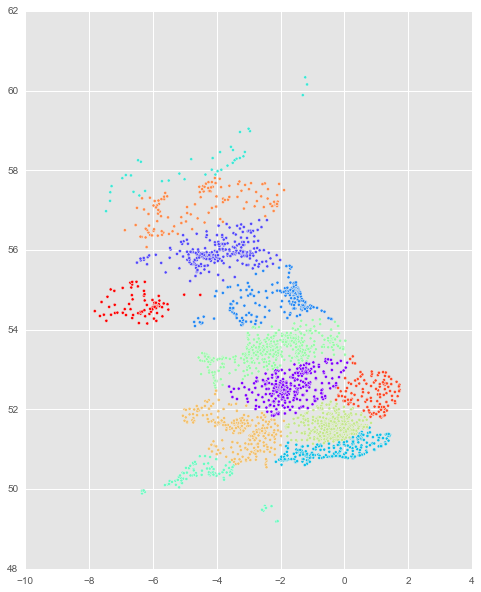

In [40]:
# Clustering using KMeans

# The goal of KMeans is to partition the feature space into K distinct clusters, with every point belonging 
# to one cluster. A good cluster is one in which the within cluster variation is minimal and the between cluster
# variation is maximal. The algorithm works as follows: K centroids are placed at random, and each data point is 
# then assigned to its nearest centroid. The centroid is then recalculated by averaging the points inside the
# cluster. This process is repeated until no points change membership of clusters.

# 12 clusters
cl = KMeans(n_clusters = 12)
model = cl.fit(distance_matrix)
labels = model.labels_
plt.figure(figsize = (8, 10))
plt.scatter(X['longitude'], X['latitude'], c= labels, cmap = 'rainbow', s = 10)
plt.show()

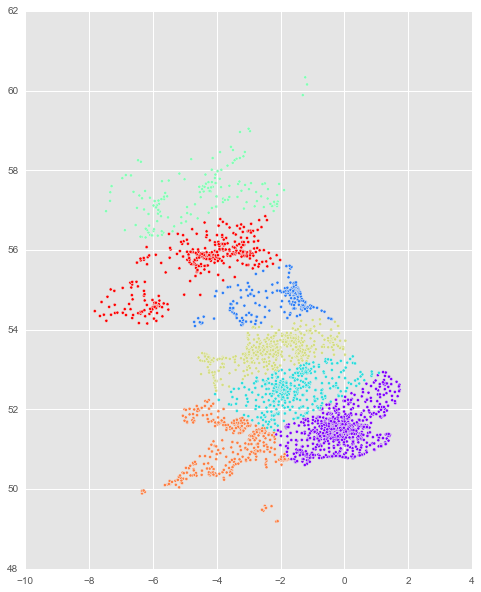

In [41]:
# 7 clusters

cl = KMeans(n_clusters = 7)
model = cl.fit(distance_matrix)
labels = model.labels_
plt.figure(figsize = (8, 10))
plt.scatter(X['longitude'], X['latitude'], c= labels, cmap = 'rainbow', s = 10)
plt.show()

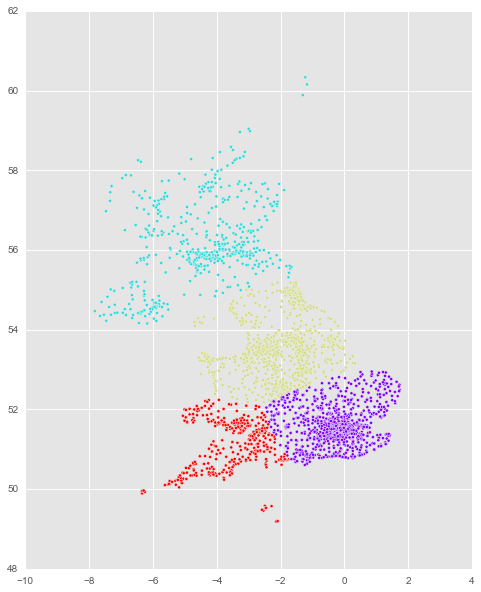

In [42]:
# 4 clusters

cl = KMeans(n_clusters = 4)
model = cl.fit(distance_matrix)
labels = model.labels_
plt.figure(figsize = (8, 10))
plt.scatter(X['longitude'], X['latitude'], c= labels, cmap = 'rainbow', s = 10)
plt.show()

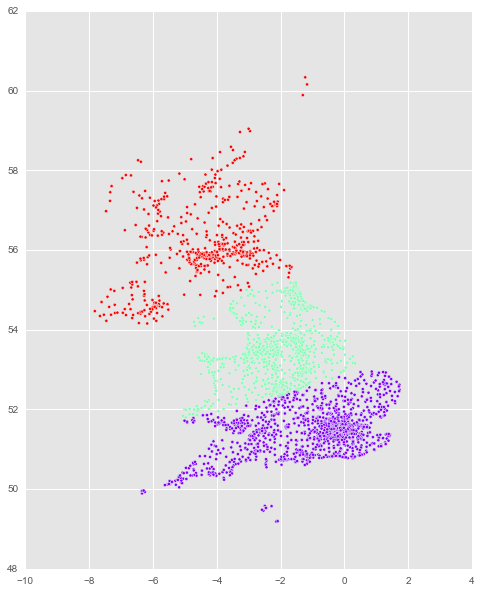

In [43]:
# 3 clusters

cl = KMeans(n_clusters = 3)
model = cl.fit(distance_matrix)
labels = model.labels_
plt.figure(figsize = (8, 10))
plt.scatter(X['longitude'], X['latitude'], c= labels, cmap = 'rainbow', s = 10)
plt.show()